# Pregunta 3

### Se tiene una partícula de masa $m = 1$ en un campo gravitacional $\vec{g} = −9.8 \hat{j}$ en una caja con piso en forma de v a un ángulo $\alpha$, de lado $L=10$ m y $d=3$ m. Realice los ejercicios con valores de $\alpha=\pi/6 \ $ y $ \ \alpha = \pi/10$.


### a)Realice una simulación con condición inicial tal que la posición inicial es sobre la rampa a un tercio de la distancia de la pared vertical izquierda y el vértice inferior de la caja, y se dispara con velocidad $\vert \vec{v} \vert = 1$ hacia la derecha con ángulos $\alpha$ sobre la horizontal $\alpha$, $2\alpha$ y $3\alpha$. (Para que la simulación sea válida, la partícula debe rebotar al menos 20 veces con alguna parte de la caja).

In [353]:
from pylab import*
from numpy import*
%matplotlib inline

In [354]:
def rk4(ec,p_ini,x,args=0,h=0.01):
    #el parámetro args está evaluándose en la segunda coordenada de la ecuación diferencial
    #éste escalar será la fricción que estamos añadiendo a la función.
    
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10.
    #codigo adicional para hacer que cuando se acerque al punto 
    #de rebote los pasos sean más pequeños y nunca sobrepase la barrera.
    
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    
    if args==0:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    else:
        for i in xrange(len(tiempos)-1): 
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args) 
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args) 
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args) 
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4) 
            
    return tiempos,sol

La ecuación para que una pelota rebote es:

$$
m\ddot{\vec{a}} = -g \hat{j}
$$

Separándola en coordenadas sería:

$$
\ddot{x_1} =0
$$

$$
\ddot{x_2} + \frac{g}{m} = 0
$$

Entonces, las ecuaciones de movimiento quedarían como:

In [355]:
#x[0]=posición_x, x[1]=posición_y, x[2]=vel_x, x[3]=vel_y

def ec_mov(x,t,g=9.8,m=1):
    dx= x[2]
    dy= x[3]
    ddy= -g/m
    ddx= 0
    return array([dx,dy,ddx,ddy])

Para imponer las condiciones de rebote con piso, vamos a pedir que la velocidad cambie de dirección cuando la pelota toque el suelo de la caja, es decir:

$$
\text{Si } \ \ \ (x_2-\vert \ x_1 \vert \tan(\alpha)) < 0 \ \ \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \ \ \vec{v}= \begin{cases}
        (v_x,-v_y) \ \ \ \ \ \ \text{ si } \ \ v_x < 0
        \\
        -(v_x,v_y) \ \ \ \ \ \ \text{ si } \ \ v_x \leq 0
        \end{cases}
$$

In [356]:
def rebote_piso(pto,ang,mi_dt):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec_mov,pto,[0,dt_busqueda])
    y_izq = pto
    y_med = sol[-1,:]
    while abs(y_izq[1]- tan(ang)*abs(y_izq[0])) > 1e-5:
        if (y_izq[1]- tan(ang)*abs(y_izq[0]))*(y_med[1]- tan(ang)*abs(y_med[0])) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec_mov,reinicio,[0,dt_busqueda])
        y_izq = reinicio   
        y_med = sol[-1,:]
    if (y_izq[0]) < 0:
        y_izq=array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
            
    else:
        y_izq=array([y_izq[0],y_izq[1],-y_izq[2],-y_izq[3]])
    return y_izq

Para imponer las condiciones de rebote con paredes, vamos a pedir que la velocidad en x cambie de dirección cuando la pelota toque la pared de la caja, es decir:

$$
\text{Si } \ \ \ (5-\vert \ x_1 \vert ) < 0 \ \ \ \ \ \ \ \ \ \ \ \Rightarrow \ \ \ \ \ \ \ \ \ \ \ \vec{v}= (-v_x,v_y)
$$

In [357]:
def rebote_pared(pto,mi_dt):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec_mov,pto,[0,dt_busqueda])
    y_izq = pto
    y_med = sol[-1,:]
    while 5 - abs(y_izq[0]) < 1e-5:
        if (5 - abs(y_izq[0]))(5 - abs(y_med[0])) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(e_mov,reinicio,[0,dt_busqueda])
        y_izq = reinicio   
        y_med = sol[-1,:]
    y_izq=array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    return y_izq

A continuación vamos a describir la trayectoria con las condiciones que impusimos:

In [358]:
def trayec(ec,p_ini,ang,mi_dt=0.1,N=500):
    trayectoria = zeros((N,len(pto_ini)))
    trayectoria[0,:]=array(pto_ini)
    for i in range(N-1):
        t,sol_dt=rk4(ec,trayectoria[i,:],[0,mi_dt])
        if sol_dt[-1,:][1] - tan(ang)*abs(sol_dt[-1,:][0]) <0 :
            punto_y = rebote_piso(trayectoria[i,:],ang,mi_dt)
            trayectoria[i+1,:] = punto_y
        elif (5 - abs(sol_dt[-1,:][0])) <0 :
            punto_x = rebote_pared(trayectoria[i,:],mi_dt)
            trayectoria[i+1,:] = punto_x
        else:
            trayectoria[i+1,:]=sol_dt[-1,:]
    return trayectoria


Las condiciones del problema son:

In [359]:
#ángulos de la caja con el piso
alpha1,alpha2=pi/6,pi/10

Como el problema pide que la pelota rebote al menos 20 veces, vamos a usar una velocidad con $\vert v \vert > 1$, sin embargo, la simulación también funciona para velocidades cuyo módulo es 1.

Como no se especifica en que ángulo está la velocidad, vamos a usar un águlo de 30º. 
(Otros ángulos también funcionan :) )

#### Para un plano inclinado de 30º

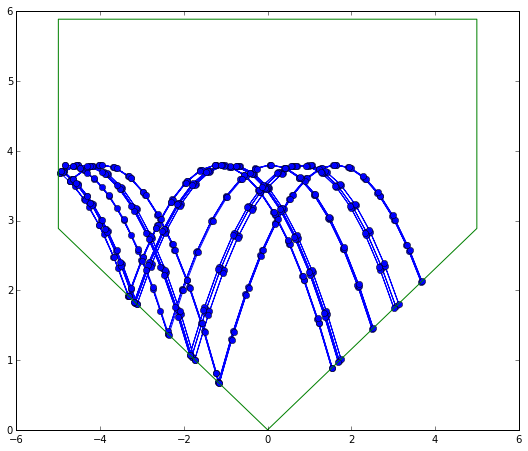

In [404]:
#Condiciones iniciales

#angulo del piso
angulo=alpha1
#angulo de la velocidad:
a=pi/3
#modulo de la velocidad
r=7
#posición
x,y=-5+5./3,tan(angulo)*(5-(5./3))
#velocidad
x_v,y_v=r*cos(a),r*sin(a)

pto_ini=[x,y,x_v,y_v]

fig = figure(figsize=(9,7.5))
trayectoria=trayec(ec_mov,pto_ini,angulo)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
#La caja
caja_x = [0,5,5,-5,-5,0]
caja_y = [0,5*tan(angulo),5*tan(angulo)+3,5*tan(angulo)+3,5*tan(angulo),0]
plot(caja_x,caja_y)
show()

#### Para un plano inclinado de 18º

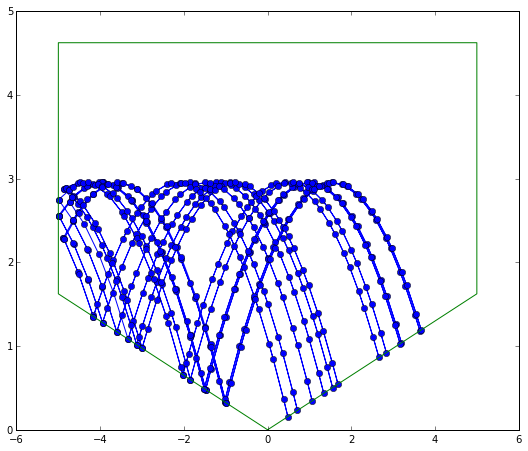

In [361]:
#Condiciones iniciales

#angulo del piso
angulo=alpha2
#angulo de la velocidad:
a=pi/3
#modulo de la velocidad
r=7
#posición
x,y=-5+5./3,tan(angulo)*(5-(5./3))
#velocidad
x_v,y_v=r*cos(a),r*sin(a)

pto_ini=[x,y,x_v,y_v]

fig = figure(figsize=(9,7.5))
trayectoria=trayec(ec_mov,pto_ini,angulo)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
#La caja
caja_x = [0,5,5,-5,-5,0]
caja_y = [0,5*tan(angulo),5*tan(angulo)+3,5*tan(angulo)+3,5*tan(angulo),0]
plot(caja_x,caja_y)
show()

### b) Introduzca algún modelo de fricción y compare las trayectorias con el inciso anterior.

En éste caso, las ecuaciones diferenciales que describen el movimiento de la una pelota son:

$$
m\ddot{\vec{a}} = -g \hat{j} -f\dot{\hat{x}}
$$

Como modelo de fricción proponemos:

$$ 
f = \mu \ \vert \ \vec{v} \ \vert^3 
$$

La anterior ecuación se puede separar en coordenadas, quedando como:

$$
\ddot{x_1} + \frac{\mu}{m} \vert \vec{v} \vert ^3 = 0
$$

$$
\ddot{x_2} + \frac{g}{m} + \frac{\mu}{m} \vert \vec{v} \vert ^3 = 0
$$

Por lo tanto las ecuaciones de mov se pueden escribir como:

In [362]:
#x[0]=posición_x, x[1]=posición_y, x[2]=vel_x, x[3]=vel_y

def ec_mov_f(x,t,mu=0.1,g=9.8,m=1):
    vel = (x[2]**2 + x[3]**2)**(1.5)
    dx = x[2]
    dy = x[3]
    ddx= - (mu/m)*vel*x[2]
    ddy= - g/m - (mu/m)*vel*x[3]
    return array([dx,dy,ddx,ddy])

Las condiciones de rebote con la pared y piso son exactamente las mismas, solo que ahora al resolver la ecuación diferencial vamos a incluir la fricción como argumento:

In [363]:
def rebote_piso_f(pto,ang,mi_dt):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec_mov_f,pto,[0,dt_busqueda])
    y_izq = pto
    y_med = sol[-1,:]
    while abs(y_izq[1]- tan(ang)*abs(y_izq[0])) > 1e-5:
        if (y_izq[1]- tan(ang)*abs(y_izq[0]))*(y_med[1]- tan(ang)*abs(y_med[0])) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec_mov_f,reinicio,[0,dt_busqueda])
        y_izq = reinicio   
        y_med = sol[-1,:]
    if (y_izq[0]) < 0:
        y_izq=array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
            
    else:
        y_izq=array([y_izq[0],y_izq[1],-y_izq[2],-y_izq[3]])
    return y_izq

In [364]:
def rebote_pared_f(pto,mi_dt):
    dt_busqueda = mi_dt/2
    t,sol = rk4(ec_mov_f,pto,[0,dt_busqueda])
    y_izq = pto
    y_med = sol[-1,:]
    while 5 - abs(y_izq[0]) < 1e-5:
        if (5 - abs(y_izq[0]))*(5 - abs(y_med[0])) < 0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t,sol = rk4(ec_mov_f,reinicio,[0,dt_busqueda])
        y_izq = reinicio   
        y_med = sol[-1,:]
    y_izq=array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    return y_izq

In [365]:
def trayec_f(ec,p_ini,ang,mi_dt=0.1,N=500):
    trayectoria = zeros((N,len(pto_ini)))
    trayectoria[0,:]=array(pto_ini)
    for i in range(N-1):
        t,sol_dt=rk4(ec,trayectoria[i,:],[0,mi_dt])
        if sol_dt[-1,:][1] - tan(ang)*abs(sol_dt[-1,:][0]) <0 :
            punto_y = rebote_piso(trayectoria[i,:],ang,mi_dt)
            trayectoria[i+1,:] = punto_y
        elif (5 - abs(sol_dt[-1,:][0])) <0 :
            punto_x = rebote_pared(trayectoria[i,:],mi_dt)
            trayectoria[i+1,:] = punto_x
        else:
            trayectoria[i+1,:]=sol_dt[-1,:]
    return trayectoria

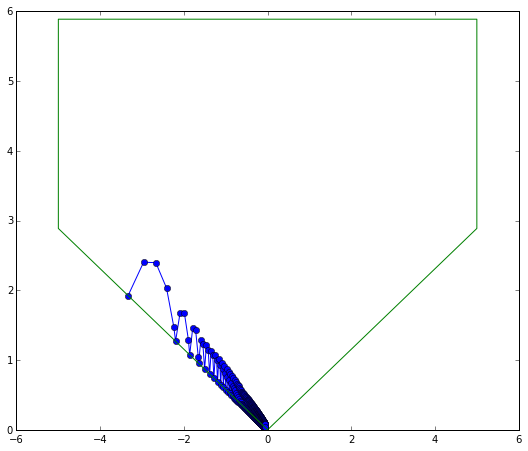

In [370]:
#Condiciones iniciales

#angulo del piso
angulo=alpha1
#angulo de la velocidad:
a=pi/3
#modulo de la velocidad
r=7
#posición
x,y=-5+5./3,tan(angulo)*(5-(5./3))
#velocidad
x_v,y_v=r*cos(a),r*sin(a)
#coeficiente de fricción
mu=0.2

pto_ini=[x,y,x_v,y_v]

fig = figure(figsize=(9,7.5))
trayectoria_f=trayec_f(ec_mov_f,pto_ini,angulo,mu)
plot(trayectoria_f[:,0],trayectoria_f[:,1],'o-')
#La caja
caja_x = [0,5,5,-5,-5,0]
caja_y = [0,5*tan(angulo),5*tan(angulo)+3,5*tan(angulo)+3,5*tan(angulo),0]
plot(caja_x,caja_y)
show()

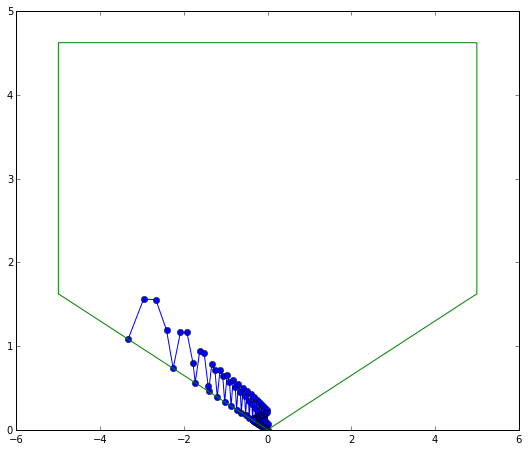

In [373]:
#Condiciones iniciales

#angulo del piso
angulo=alpha2
#angulo de la velocidad:
a=pi/3
#modulo de la velocidad
r=7
#posición
x,y=-5+5./3,tan(angulo)*(5-(5./3))
#velocidad
x_v,y_v=r*cos(a),r*sin(a)
#coeficiente de fricción
mu=0.2

pto_ini=[x,y,x_v,y_v]

fig = figure(figsize=(9,7.5))
trayectoria_f=trayec_f(ec_mov_f,pto_ini,angulo,mu)
plot(trayectoria_f[:,0],trayectoria_f[:,1],'o-')
#La caja
caja_x = [0,5,5,-5,-5,0]
caja_y = [0,5*tan(angulo),5*tan(angulo)+3,5*tan(angulo)+3,5*tan(angulo),0]
plot(caja_x,caja_y)
show()

### c) Dibuje el espacio fase $p_x$ , $x$ y $p_y$ , $y$ cuando no hay fricción y la partícula es lanzada hacia la derecha a un ángulo $\alpha$ y vertical hacia arriba. Tome en cuenta el número necesario de rebotes para que la simulación pueda barrer el espacio fase de manera representativa.

Notemos que como m=1, basta graficar $v_i$ contra $x_i$ en cada caso, entonces:

#### Para un ángulo $\alpha=\pi/3$

In [ ]:
#Condiciones iniciales

#angulo del piso
angulo=alpha1
#angulo de la velocidad:
a=pi/3
#modulo de la velocidad
r=7
#posición
x,y=-5+5./3,tan(angulo)*(5-(5./3))
#velocidad
x_v,y_v=r*cos(a),r*sin(a)

pto_ini=[x,y,x_v,y_v]

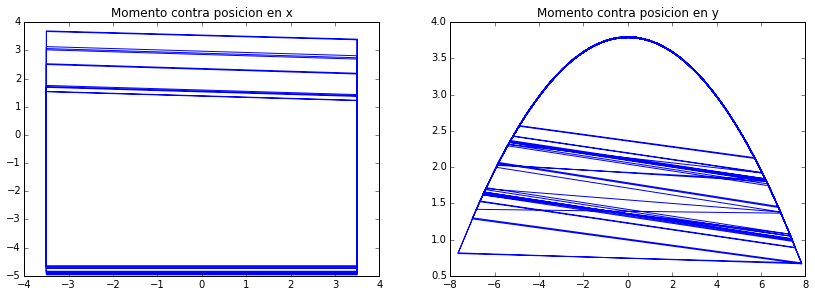

In [397]:
fig = figure(figsize=(14,10))

bla=trayec(ec_mov,pto_ini,angulo)

a1 = fig.add_subplot(221)
plot(bla[:,2],bla[:,0])
title('Momento contra posicion en x')
a2 = fig.add_subplot(222)
plot(bla[:,3],bla[:,1])
title('Momento contra posicion en y')
show()

#### Para un ángulo $\alpha=\pi/2$

In [401]:
#Condiciones iniciales

#angulo del piso
angulo=alpha1
#angulo de la velocidad:
a2=pi/2
#modulo de la velocidad
r=7
#posición
x,y=-5+5./3,tan(angulo)*(5-(5./3))
#velocidad
x_v,y_v=r*cos(a2),r*sin(a2)

pto_ini2=[x,y,x_v,y_v]

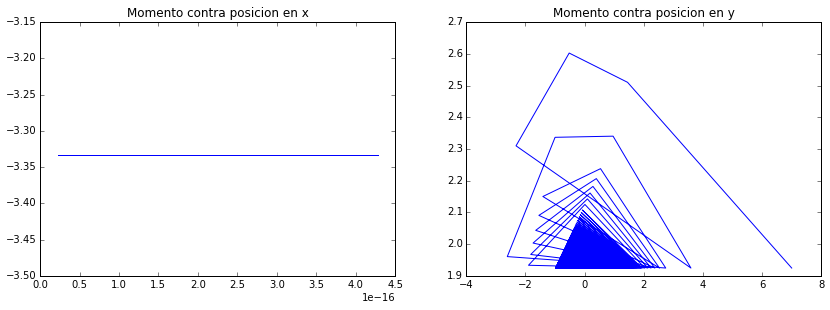

In [402]:
fig = figure(figsize=(14,10))

bla_f=trayec_f(ec_mov_f,pto_ini2,angulo,mu)

a1 = fig.add_subplot(221)
plot(bla_f[:,2],bla_f[:,0])
title('Momento contra posicion en x')
a2 = fig.add_subplot(222)
plot(bla_f[:,3],bla_f[:,1])
title('Momento contra posicion en y')
show()